In [ ]:
import xgboost
import shap 

import numpy as np
from cell_paint_seg.utils import get_id_to_path, check_valid_labels, threat_score
from cell_paint_seg.image_io import read_ims, read_seg
from skimage import io, exposure, measure, transform
from pathlib import Path
import napari
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score 
from PIL import Image

# Universal

In [ ]:
def id_from_name_dataset(name):
    id = name[:-7]
    return id 

def condition_from_id(id):
    row_to_roid = {"B":0, "C":1, "D":2, "E":3, "F":4, "G":5}

    well = id.split("_")[1]
    row = well[1]
    row = row_to_roid[row]
    col = int(well[2:])
    col -= 2

    conditions = [[1,1,2,2,5,1,1,4,5,5],
                  [3,3,4,4,5,2,2,4,3,3],
                  [5,2,2,1,1,2,2,3,3,5],
                  [3,3,4,4,5,5,4,4,1,1],
                  [4,4,1,1,3,2,2,1,3,3],
                  [5,5,2,2,3,5,5,1,4,4]]
    
    return conditions[row][col] - 1

def line_from_id(id):
    row_to_roid = {"B":0, "C":1, "D":2, "E":3, "F":4, "G":5}

    e = int(id[1])
    well = id.split("_")[1]
    row = well[1]
    row = row_to_roid[row]
    col = int(well[2:])

    if row < 2:
        if col < 7:
            e_to_line = {1:"RFTiALS", 2:"AE8iCTR", 3:"ADKiCTR", 4:"EGMiALS"}
        else:
            e_to_line = {1:"AE8iCTR", 2:"BFUiALS", 3:"ZLMiALS", 4:"XH7iCTR"}
    elif row < 4:
        if col < 7:
            e_to_line = {1:"ZKZiCTR", 2:"KRCiALS", 3:"BFUiALS", 4:"ADKiCTR"}
        else:
            e_to_line = {1:"TJViALS", 2:"XH7iCTR", 3:"NK3iCTR", 4:"LJXiALS"}
    else:
        if col < 7:
            e_to_line = {1:"DG9iALS", 2:"ZKZiCTR", 3:"ZKZiCTR", 4:"NK3iCTR"}
        else:
            e_to_line = {1:"XH7iCTR", 2:"RJViALS", 3:"AFGiALS", 4:"AE8iCTR"}
    
    
    return e_to_line[e]

path_dataset = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/processed"


cond_to_cond = {1: "KPT", 2:"H2O2", 3:"Tunicamycin", 4:"Autophagy", 5:"DMSO"}
channels = ["ER", "DNA", "Mito", "Actin", "RNA", "Golgi/membrane"]
res = 6.9e-7

id_to_path = get_id_to_path(path_dataset, tag=".tif", id_from_name=id_from_name_dataset)

print(f"{len(id_to_path.keys())} samples found")

# Make Dataset

In [95]:
tile_test = True
ds_size = 64
data = []
y = []
for id, paths in tqdm(id_to_path.items()):
    condition = condition_from_id(id)
    line = line_from_id(id)
    if "ALS" in line:
        disease = 1
    else:
        disease = 0
    exp = int(id[1])
    ims = read_ims(paths)

    if exp == 4:
        ims = [transform.resize(im, (ds_size,ds_size), anti_aliasing=True) for im in ims]
        if tile_test:
            for x0 in range(0, ds_size, 16):
                for y0 in range(0, ds_size, 16):
                    ims_flat = [im[x0:x0+16,y0:y0+16].flatten() for im in ims]
                    x = np.concatenate(ims_flat + [[disease, condition, exp]], axis=0)
                    data.append(x)
        else:
            ims_flat = [im[8:24,8:24].flatten() for im in ims]
            x = np.concatenate(ims_flat + [[disease, condition, exp]], axis=0)
            data.append(x)
    else:
        ims = [transform.resize(im, (ds_size,ds_size), anti_aliasing=True) for im in ims]
        for x0 in range(0, ds_size, 16):
            for y0 in range(0, ds_size, 16):
                ims_flat = [im[x0:x0+16,y0:y0+16].flatten() for im in ims]
                x = np.concatenate(ims_flat + [[disease, condition, exp]], axis=0)
                data.append(x)



data = np.stack(data, axis=0)
columns = [f"{channel}_{i}" for channel in channels for i in range(ims_flat[0].size)] + ["Disease", "Condition", "Experiment"]

df = pd.DataFrame(data, columns=columns)
df.shape  

  0%|          | 0/720 [00:00<?, ?it/s]

(11520, 1539)

In [115]:
data = np.stack(data, axis=0)
columns = [f"{channel}_{i}" for channel in channels for i in range(ims_flat[0].size)] + ["Disease", "Condition", "Experiment"]

df = pd.DataFrame(data, columns=columns)
df.shape  

(11520, 1539)

In [116]:
df = df[df["Condition"] == 0]

In [117]:
separate_plates = True 

dep_var = "Disease"

for exclude in range(1,5):
    if separate_plates:
        df_train = df[df["Experiment"] != exclude]
        df_test = df[df["Experiment"] == exclude]

        x_train = df_train.drop(columns=["Condition", "Experiment", "Disease"])
        y_train = df_train[dep_var].values
        x_test = df_test.drop(columns=["Condition", "Experiment", "Disease"])
        y_test = df_test[dep_var].values
    else:
        raise NotImplementedError()
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15, stratify=y)

    model = xgboost.XGBClassifier().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)

    confusion_mat = confusion_matrix(y_test,y_pred)

    print("Accuracy is",acc)
    print("Confusion Matrix")
    print(confusion_mat)

Accuracy is 0.5520833333333334
Confusion Matrix
[[194  94]
 [164 124]]
Accuracy is 0.5989583333333334
Confusion Matrix
[[226  62]
 [169 119]]
Accuracy is 0.5538194444444444
Confusion Matrix
[[220  68]
 [189  99]]
Accuracy is 0.6076388888888888
Confusion Matrix
[[177 207]
 [ 19 173]]


# Predict

In [104]:
model = xgboost.XGBClassifier().fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)

confusion_mat = confusion_matrix(y_test,y_pred)

print("Accuracy is",acc)
print("Confusion Matrix")
print(confusion_mat)

Accuracy is 0.6076388888888888
Confusion Matrix
[[177 207]
 [ 19 173]]


In [105]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(x_test)


In [106]:
print(f"values: {shap_values.values.shape}, base_values: {shap_values.base_values.shape}, data: {shap_values.data.shape}")
# data is just data
# base_values is the expected value of the model (one for each class - prior distribution?
# values is the shapley values for each feature nxdxk where each entry is contribution of that sample's feature to that class

values: (576, 1536), base_values: (576,), data: (576, 1536)


In [ ]:
# # visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0,:,0])
print(shap_values.values[0,5*256+60,0])
print(shap_values.data[0,5*256+60])
print(shap_values.base_values[0,0])
print(np.sum(shap_values.values[0,:,0])+shap_values.base_values[0,0])

In [ ]:
for condition in range(5):
    channel_sums = np.zeros((shap_values.shape[0], len(channels)))

    for sample in range(shap_values.shape[0]):
        for channel in range(len(channels)):
            channel_sums[sample, channel] = np.abs(np.sum(shap_values.values[sample,channel*256:(channel+1)*256,condition]))

    df = pd.DataFrame(channel_sums, columns=channels)

    sns.stripplot(df)
    plt.title(f"{cond_to_cond[condition+1]}")
    plt.show()

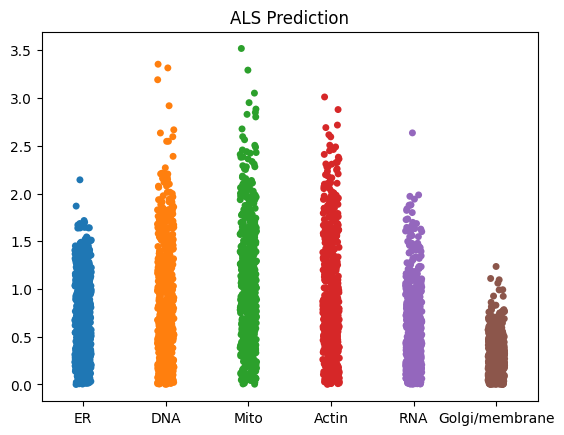

In [107]:
channel_sums = np.zeros((shap_values.shape[0], len(channels)))

for sample in range(shap_values.shape[0]):
    for channel in range(len(channels)):
        channel_sums[sample, channel] = np.abs(np.sum(shap_values.values[sample,channel*256:(channel+1)*256]))

df = pd.DataFrame(channel_sums, columns=channels)

sns.stripplot(df)
plt.title(f"ALS Prediction")
plt.show()